In [4]:
import pandas as pd
import os
import shutil

CWD = os.getcwd()

DATA_DIR = f"{CWD}/data"
TRAIN_DIR = f"{DATA_DIR}/Train"
VAL_DIR = f"{DATA_DIR}/Val"

In [5]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Flatten, Concatenate, Input
import keras.preprocessing
import utils
import mlflow
import mlflow.keras
from PIL import Image

## Loading and processing data

In [6]:
train_datagen = keras.preprocessing.image.ImageDataGenerator()
test_dataset = keras.preprocessing.image.ImageDataGenerator()

In [7]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = (128,128),
    batch_size = 32,
    class_mode = "categorical",
    color_mode = "grayscale"
)

Found 288 images belonging to 2 classes.


In [8]:
val_generator = test_dataset.flow_from_directory(
    VAL_DIR,
    target_size = (128,128),
    batch_size = 32,
    class_mode = "categorical",
    color_mode = "grayscale"
)

Found 60 images belonging to 2 classes.


## Baseline CNN

<a href="https://ibb.co/Pjcx7RL"><img src="https://i.ibb.co/MScnYbv/Screenshot-2023-05-04-at-21-58-30.png" alt="Screenshot-2023-05-04-at-21-58-30" border="0"></a>

In [9]:
baseline_model = Sequential([
    Conv2D(4, (3,3)),
    Conv2D(10, (7,7)),
    Conv2D(10, (7,7)),
    Conv2D(2, (1,1)),
    Flatten(),
    Dense(10),
    Dense(2, activation = "softmax")
])

baseline_model.compile(
    loss = keras.losses.categorical_crossentropy,
    optimizer = "adam",
    metrics = ["accuracy"])

Metal device set to: Apple M1


In [10]:
mlflow.keras.autolog()
baseline_hist = baseline_model.fit(
    train_generator,
    steps_per_epoch = 8,
    epochs = 10,
    validation_data = val_generator,
    validation_steps = 2,
    verbose = 0
)

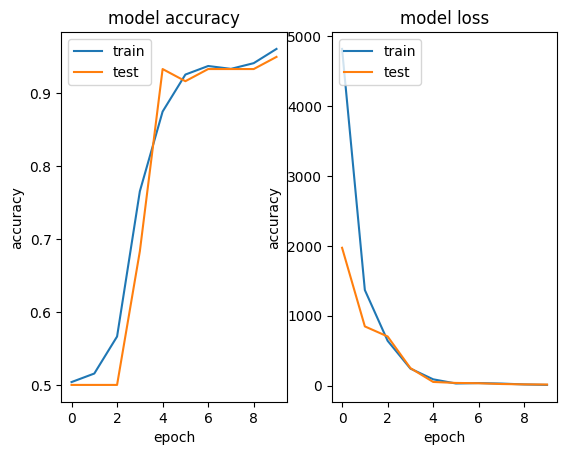

baseline model accuracy (val): 0.9500000476837158


In [11]:
utils.visualize_history(baseline_hist, name = "baseline")

## Prepare topological features

According to the paper we calculate 0-dimensional persistence diagram of the lower-star filtartion.

In [9]:
import numpy as np
from ripser import Rips
import ripser
from persim import plot_diagrams
from gtda.diagrams import BettiCurve
import math

rips = Rips()

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [10]:
batch_images_train, batch_labels_train = [], []

for _ in range(math.ceil(train_generator.samples / train_generator.batch_size)):
    data, label = train_generator.next()
    batch_images_train.extend(data)
    batch_labels_train.extend(label)

batch_images_test, batch_labels_test = [], []

for _ in range(math.ceil(val_generator.samples / val_generator.batch_size)):
    data, label = val_generator.next()
    batch_images_test.extend(data)
    batch_labels_test.extend(label)

batch_images_train = np.array(batch_images_train)
batch_labels_train = np.array(batch_labels_train)

batch_images_test = np.array(batch_images_test)
batch_labels_test = np.array(batch_labels_test)

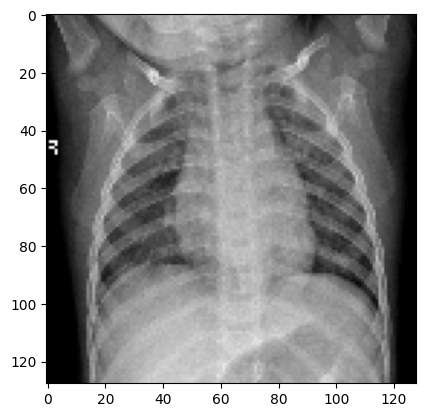

In [11]:
# The flow_from_directory method with color_mode='grayscale' returns a 3D array
vectorized_images = np.array(
    batch_images_train[:len(batch_images_train)]
    ).reshape(-1, 128, 128) / 255.0

plt.imshow(vectorized_images[0], cmap='gray')
plt.show()

In [12]:
dgms = [ripser.lower_star_img(-img) for img in vectorized_images]

Preview of an example persistence diagram.

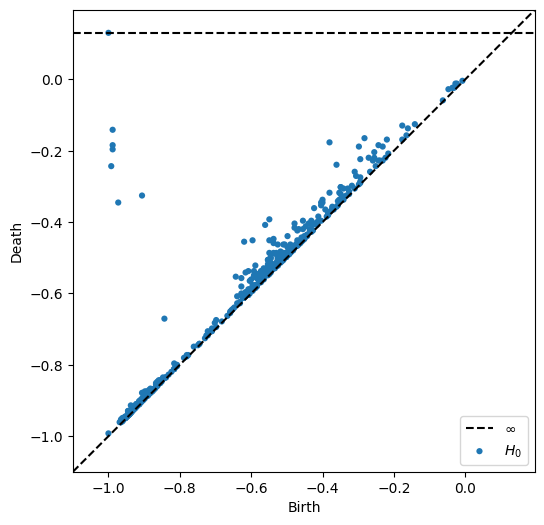

In [13]:
plt.figure(figsize=(6, 6))
plot_diagrams(dgms[11], lifetime=False)
plt.show()

I remove homologies that never die ($death \rightarrow inf$). Without that I can not calculate betti-curve as it calculates $y = y * step$ at one point.

In [14]:
# change a format to fit into package that calculates betti-curve

dgms_processed = [
    [[(pt[0], pt[1], 0) for pt in dgm[:-1]]]
    for dgm in dgms
]

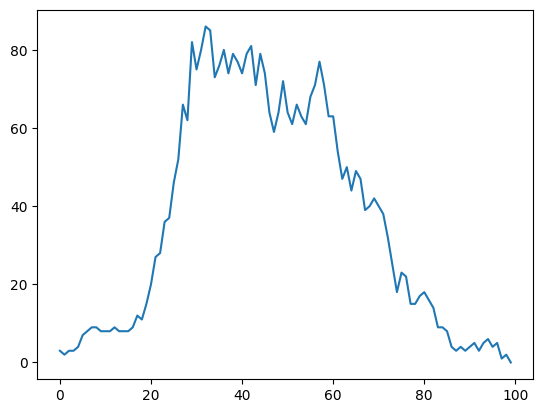

In [15]:
bc = BettiCurve() # n_bins is 100 by default

betti_curves = np.array([
    bc.fit_transform(X = dgm)[0][0]
    for dgm in dgms_processed
])

plt.plot(betti_curves[10]) # random example betti-curve
plt.show()

Above code after development was transformed into a single function to easily use it later on.

In [16]:
X_train_1st_tda_net = utils.transform_images_to_betti_curves(batch_images_train)
y_train_1st_tda_net = batch_labels_train

X_test_1st_tda_net = utils.transform_images_to_betti_curves(batch_images_test)
y_test_1st_tda_net = batch_labels_test

In [15]:
y_train_1st_tda_net.shape

(288, 2)

## 1st TDA-Net model

<a href="https://imgbb.com/"><img src="https://i.ibb.co/6XvP1t5/Screenshot-2023-05-04-at-20-46-07.png" alt="Screenshot-2023-05-04-at-20-46-07" border="0"></a>

In [16]:
first_tda_net_model = Sequential([
    Dense(300),
    Dense(600),
    Dense(200),
    Dense(200),
    Dense(2, activation = "softmax")
])

first_tda_net_model.compile(
    loss = keras.losses.categorical_crossentropy,
    optimizer = "adam",
    metrics = ["accuracy"])

first_tda_net_hist = first_tda_net_model.fit(
    x = X_train_1st_tda_net,
    y = y_train_1st_tda_net,
    steps_per_epoch = 8,
    epochs = 10,
    validation_data = (
        X_test_1st_tda_net,
        y_test_1st_tda_net
    ),
    validation_steps = 2,
    verbose = 0
    )

Metal device set to: Apple M1


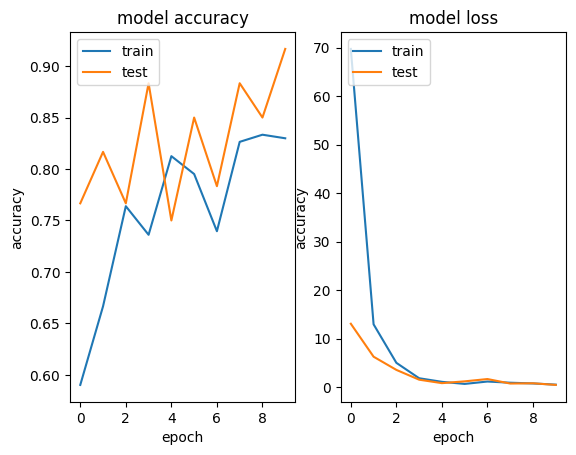

first_tda_net model accuracy (val): 0.9166666865348816


In [17]:
utils.visualize_history(first_tda_net_hist, name = "first_tda_net")

In [31]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred = (first_tda_net_model.predict(X_test_1st_tda_net) > 0.5).astype("int32")

print(precision_score(y_test_1st_tda_net, y_pred , average="macro"))

2/2 [==============================] - 0s 11ms/step
0.8872053872053872


## 2nd TDA-Net model

In [17]:
second_tda_net_deep_stream_input_layer = Input(shape=(128, 128, 1))
second_tda_net_topological_stream_input_layer = Input(shape=(100,))

second_tda_net_deep_stream = Sequential([
    Conv2D(4, (3,3)),
    Conv2D(10, (7,7)),
    Conv2D(10, (7,7)),
    Conv2D(2, (1,1)),
    Flatten()
], name = "deep_stream")

second_tda_net_deep_stream_output = second_tda_net_deep_stream(
    second_tda_net_deep_stream_input_layer
)

second_tda_net_topological_stream = Sequential([
    Dense(200),
    Dense(200),
    Dense(100),
], name = "topological_stream")

second_tda_net_topological_stream_output = second_tda_net_topological_stream(
    second_tda_net_topological_stream_input_layer
)

concatenated_outputs = Concatenate()([second_tda_net_deep_stream_output,
                                      second_tda_net_topological_stream_output])


dense_layer = Dense(10)(concatenated_outputs)

final_output = Dense(2, activation = "softmax")(dense_layer)

model_inputs = [second_tda_net_deep_stream_input_layer,
                second_tda_net_topological_stream_input_layer]

model_outputs = [final_output]

second_tda_net_model = Model(
    inputs=model_inputs,
    outputs=model_outputs)

second_tda_net_model.compile(
    loss = keras.losses.categorical_crossentropy,
    optimizer = "adam",
    metrics = ["accuracy"]
)

second_tda_net_hist = second_tda_net_model.fit(
    x = [batch_images_train, X_train_1st_tda_net],
    y = y_train_1st_tda_net,
    steps_per_epoch = 8,
    epochs = 10,
    validation_data = (
        [batch_images_test, X_test_1st_tda_net],
        y_test_1st_tda_net
    ),
    validation_steps = 2,
    verbose = 0
)

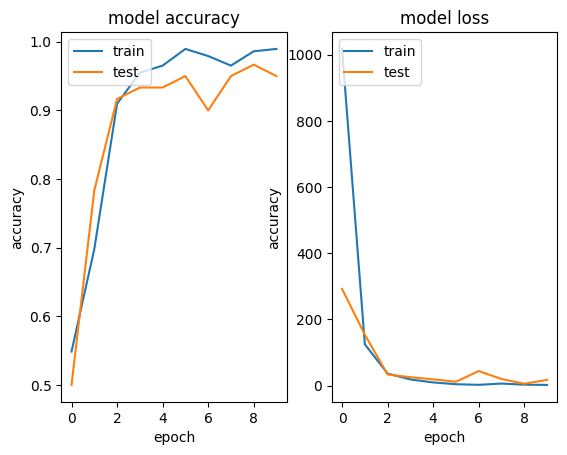

second_tda_net model accuracy (val): 0.9500000476837158


In [18]:
utils.visualize_history(second_tda_net_hist, name = "second_tda_net")

In [19]:
utils.plot_model_custom(second_tda_net_model, "second_tda_net_model")